Quick experiment to see which is better at detecting truthful answers

- model outputs
- hs
- supressed activations (Hypothesis this is better)

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import rearrange
from tqdm import tqdm
from activation_store.collect import activation_store

import torch

## Load model

In [ ]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager",  # flex_attention  flash_attention_2 sdpa eager
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


## Load data and tokenize

In [ ]:
# N = 316
max_length = 128
split='train'
ds1 = load_dataset('Yik/truthfulQA-bool', split=split, keep_in_memory=False)

sys_msg = """You will be given a statement, predict if it is true according to wikipedia, and return only 0 for false and 1 for true.
"""

def proc(row):
    messages = [
        {"role":"system", "content": sys_msg},
        {"role":"user", "content": row['question'] },
    ]
    return tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_dict=True, max_length=max_length)

ds2 = ds1.map(proc).with_format("torch")
new_cols = list(set(ds2.column_names) - set(ds1.column_names)) +['label']
ds2 = ds2.select_columns(new_cols)
ds2

## Data loader

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(examples):
    # Pad the batch to max length within this batch
    return tokenizer.pad(
        examples,
        padding=True,
        return_tensors="pt",
        padding_side="left",   
        max_length=max_length,  
        # truncate=True,   
    )
ds = DataLoader(ds2, batch_size=6, collate_fn=collate_fn)
print(ds)


## Collect activations

In [ ]:
f = activation_store(ds, model)
f

In [ ]:
from datasets import Dataset
ds_a = Dataset.from_parquet(str(f), split=split).with_format("torch")
ds_a

In [ ]:
# sanity test generate
b = next(iter(ds))
b = {k: v.to(model.device) for k, v in b.items()}
o = model.generate(inputs = b['input_ids'], attention_mask=b['attention_mask'], max_new_tokens=6,)
gent = tokenizer.batch_decode(o, skip_special_tokens=False)
for g in gent:
    print(g)
    print('---')

## Get supressed activations

In [ ]:
from jaxtyping import Float, Int
from torch import Tensor
from einops import rearrange


def get_supressed_activations(
    hs: Float[Tensor, "l b t h"], w_out, w_inv
) -> Float[Tensor, "l b t h"]:
    """
    Novel experiment: Here we define a transform to isolate supressed activations, where we hypothesis that style/concepts/scratchpads and other internal only representations must be stored.

    See the following references for more information:

    - https://arxiv.org/pdf/2401.12181
        - > Suppression neurons that are similar, except decrease the probability of a group of related tokens

    - https://arxiv.org/html/2406.19384
        - > Previous work suggests that networks contain ensembles of “prediction" neurons, which act as probability promoters [66, 24, 32] and work in tandem with suppression neurons (Section 5.4).

    - https://arxiv.org/pdf/2401.12181
        > We find a striking pattern which is remarkably consistent across the different seeds: after about the halfway point in the model, prediction neurons become increasingly prevalent until the very end of the network where there is a sudden shift towards a much larger number of suppression neurons.
    """
    with torch.no_grad():
        # here we pass the hs through the last layer, take a diff, and then project it back to find which activation changes lead to supressed
        hs2 = rearrange(hs[:, :, -1:], "l b t h -> (l b t) h")
        hs_out2 = torch.nn.functional.linear(hs2, w_out)
        hs_out = rearrange(
            hs_out2, "(l b t) h -> l b t h", l=hs.shape[0], b=hs.shape[1], t=1
        )
        diffs = hs_out[:, :, :].diff(dim=0)
        diffs2 = rearrange(diffs, "l b t h -> (l b t) h")
        # W_inv = get_cache_inv(w_out)

        diffs_inv2 = torch.nn.functional.linear(diffs2.to(dtype=w_inv.dtype), w_inv)
        diffs_inv = rearrange(
            diffs_inv2, "(l b t) h -> l b t h", l=hs.shape[0] - 1, b=hs.shape[1], t=1
        ).to(w_out.dtype)
        # TODO just return this?
        eps = 1.e-2
        supressed_mask = (diffs_inv < -eps).to(hs.dtype)
        # supressed_mask = repeat(supressed_mask, 'l b 1 h -> l b t h', t=hs.shape[2])
    supressed_act = hs[1:] * supressed_mask
    return supressed_act, supressed_mask

In [ ]:
# tokenizer.encode?

In [ ]:


def get_uniq_token_ids(tokens):
    token_ids = tokenizer(tokens, return_tensors="pt", add_special_tokens=False, padding=True).input_ids
    token_ids = torch.tensor(list(set([x[0] for x in token_ids]))).long()
    print('before', tokens)
    print('after', tokenizer.batch_decode(token_ids))
    return token_ids

false_tokens = ["0", "0 ", "0\n", "false", "False "]
false_token_ids = get_uniq_token_ids(false_tokens)

true_tokens = ["1", "1 ", "1\n", "true", "True "]
true_token_ids = get_uniq_token_ids(true_tokens)

In [ ]:
# now we map to 1) calc supressed activations 2) llm answer (prob of 0 vs prob of 1)

Wo = model.get_output_embeddings().weight.detach().clone().cpu()
Wo_inv = torch.pinverse(Wo.clone().float())

def proc(o):

    # get llm ans
    log_probs = o['logits'][-1].log_softmax(0)
    false_log_prob = log_probs.index_select(0, false_token_ids).sum()
    true_log_prob = log_probs.index_select(0, true_token_ids).sum()
    o['llm_ans'] = torch.stack([false_log_prob, true_log_prob
    ])
    o['llm_log_prob_true'] = true_log_prob - false_log_prob

    # get supressed activations
    hs = o['hidden_states'][None]
    hs = rearrange(hs, "b l t h -> l b t h")
    layer_half = hs.shape[0] // 2
    hs_s, supressed_mask = get_supressed_activations(hs, Wo.to(hs.dtype), Wo_inv.to(hs.dtype))
    hs_s = rearrange(hs_s, "l b t h -> b l t h").squeeze(0)
    # we will only take the last half of layers, and the last token
    hs_s = hs_s[layer_half:-2, :]
    o['hs_sup'] = hs_s.half()

    supressed_mask = rearrange(supressed_mask, "l b t h -> b l t h").squeeze(0)
    supressed_mask = supressed_mask[layer_half:-2, :]
    o['supressed_mask'] = supressed_mask

    # should I just get the last token for the hs, and only the later layers
    o['hidden_states'] = o['hidden_states'][layer_half:-2, ]
    return o

ds_a2 = ds_a.map(proc, writer_batch_size=1, num_proc=None)
ds_a2

## Predict

In [91]:
from sklearn.datasets import make_classification
from torch import nn
from torch.nn import functional as F
from skorch import NeuralNetClassifier

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

class MyModule(nn.Module):
    def __init__(self, input_shape, hs=10, depth=1, nonlin=nn.ReLU(), output_shape=1):
        super().__init__()

        layers = []
        for i in range(depth-1):
            layers.append(nn.Linear(input_shape, hs))
            layers.append(nonlin)
            input_shape = hs
        layers.append(nn.Linear(input_shape, output_shape))
        self.layers = nn.Sequential(*layers)

    def forward(self, X, **kwargs):
        X = self.layers(X)
        return F.sigmoid(X)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_classifier(input_shape):
    return  NeuralNetClassifier(
        MyModule(input_shape).to(device),
        max_epochs=10,
        lr=0.1,
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
        criterion=torch.nn.BCELoss,
    )



In [138]:
tt_split = 200
a= torch.sigmoid(-ds_a2['llm_log_prob_true'])
b =ds_a2['label']
llm_score = roc_auc_score(b[tt_split:], a[tt_split:])
print(f'LLM score: {llm_score:.2f} roc auc, n={len(a[tt_split:])}')

LLM score: 0.57 roc auc, n=116


### with hidden states

In [160]:
def train_linear_prob_on_dataset(X, name="", device: str = "cuda", ):
    # print(X.shape)
    X = X.view(len(X), -1).to(device)

    # norm X
    X = (X - X.mean()) / X.std()

    y = ds_a2['label'].to(device).unsqueeze(1).float()
    X_train, y_train = X[:tt_split], y[:tt_split]
    X_test, y_test = X[tt_split:], y[tt_split:]
    # data.shape
    lr_model = make_classifier(X.shape[-1])
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict_proba(X_test)[:, 1]

    score = roc_auc_score(y_test.cpu(), y_pred)

    y_train_pred = lr_model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train.cpu(), y_train_pred)
    print(f'score for probe({name}): {score:.3f} roc auc, n={len(X_test)}')
    return lr_model, dict(score_val=score, train_score=train_score)

In [183]:
X = ds_a2[dn]
X[0].shape

torch.Size([10, 56, 896])

In [186]:
reductions = {
    'mean': lambda x: x.mean(0),
    'max': lambda x: x.max(0)[0],
    'min': lambda x: x.min(0)[0],
    'sum': lambda x: x.sum(0),
    'last': lambda x: x[-1],
    'first': lambda x: x[0],
    'none': lambda x: x,
    'std': lambda x: x.std(0),
}
results = []
data_names = ['hs_sup', 'hidden_states', 'supressed_mask']
for dn in data_names:
    X = ds_a2[dn]
    print(f'0 running {dn} {X[0].shape}')
        
    for r1 in reductions:
        r1f = reductions[r1]
        for r2 in reductions:
            r2f = reductions[r2]
            name = f'{dn} {r1} {r2}'
            try:
                X2 = torch.stack([r2f(r1f(x)) for x in X])
                print(f'1 running {name} {X2.shape}')
                lr_model, d = train_linear_prob_on_dataset(X2, name)
                d['name'] = name
                results.append(d)
            except Exception as e:
                print(f'failed {name} {e}')
                # raise e


0 running hs_sup torch.Size([10, 56, 896])
1 running hs_sup mean mean torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4637       0.5000        1.5443  0.0760
      2       11.5983       0.5000       20.6614  0.0037
      3       38.7569       0.5000       13.2462  0.0026
      4       23.8658       0.5000        9.7677  0.0026
      5        9.5366       0.5000       13.2541  0.0024
      6       23.9117       0.5000       11.9819  0.0024
      7       12.5148       0.5000        3.8726  0.0022
      8       10.4365       0.5000        7.8465  0.0021
      9       12.9239       0.5000       10.1725  0.0027
     10       15.7811       0.5000       10.7773  0.0026
score for probe(hs_sup mean mean): 0.405 roc auc, n=116
1 running hs_sup mean max torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
    

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


      8        3.4192       0.4500        3.5024  0.0026
      9        3.3982       0.4750        3.4630  0.0023
     10        3.2145       0.4750        3.9524  0.0022
score for probe(supressed_mask max min): 0.526 roc auc, n=116
1 running supressed_mask max sum torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7004       0.6000        1.0596  0.0029
      2        0.9839       0.5000        0.7600  0.0026
      3        0.9350       0.5250        1.9557  0.0024
      4        1.7900       0.5000        2.0162  0.0023
      5        1.8515       0.4750        2.3314  0.0023
      6        1.8686       0.4750        2.4827  0.0023
      7        1.9910       0.5000        2.0399  0.0036
      8        1.9440       0.5000        1.9758  0.0028
      9        1.8814       0.5250        1.9526  0.0027
     10        2.3918       0.5000        2.1608  0.0026
score for probe(supressed_m

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


     10        8.6902       0.6250       10.7438  0.0024
score for probe(supressed_mask min min): 0.538 roc auc, n=116
1 running supressed_mask min sum torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7021       0.5500       10.7680  0.0026
      2        8.7582       0.5250       10.8015  0.0023
      3        8.6953       0.5250       10.7097  0.0024
      4        8.6856       0.5250       10.7671  0.0022
      5        8.6899       0.5250       10.6385  0.0023
      6        8.6770       0.5500       10.7133  0.0021
      7        8.7307       0.5250       10.8886  0.0021
      8        8.7049       0.5250       10.7554  0.0022
      9        8.6887       0.5500       10.7125  0.0022
     10        8.7301       0.5250       10.8989  0.0022
score for probe(supressed_mask min sum): 0.538 roc auc, n=116
1 running supressed_mask min last torch.Size([316, 896])
  epoch    train_loss 

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


      2       20.1462       0.5000       20.9796  0.0028
      3       20.1461       0.5000       20.9796  0.0025
      4       20.1461       0.5000       20.9795  0.0026
      5       20.1460       0.5000       20.9795  0.0024
      6       20.1459       0.5000       20.9794  0.0024
      7       20.1459       0.5000       20.9793  0.0026
      8       20.1458       0.5000       20.9793  0.0027
      9       20.1457       0.5000       20.9792  0.0032
     10       20.1457       0.5000       20.9791  0.0028
score for probe(supressed_mask sum sum): 0.624 roc auc, n=116
1 running supressed_mask sum last torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9301       0.5000       50.0000  0.0027
      2       51.8750       0.5000       50.0000  0.0026
      3       51.8750       0.5000       50.0000  0.0026
      4       51.8750       0.5000       50.0000  0.0028
      5       51.8750     

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


      3        9.2969       0.5000        5.1715  0.0027
      4        5.8924       0.5500        1.1376  0.0026
      5        2.0290       0.5000        4.6059  0.0025
      6        6.2694       0.5000        4.0579  0.0024
      7       11.6820       0.5000       50.0000  0.0025
      8       51.8750       0.5000       50.0000  0.0024
      9       51.8750       0.5000       50.0000  0.0025
     10       51.8750       0.5000       50.0000  0.0024
score for probe(supressed_mask last sum): 0.500 roc auc, n=116
1 running supressed_mask last last torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8496       0.5000       12.2556  0.0025
      2        9.7839       0.5000       11.5603  0.0025
      3       10.4141       0.5000       14.1496  0.0027
      4       11.2525       0.5000       50.0000  0.0024
      5       51.8750       0.5000       50.0000  0.0025
      6       51.8750   

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


      2       51.8750       0.5000       50.0000  0.0030
      3       51.8750       0.5000       50.0000  0.0029
      4       51.8750       0.5000       50.0000  0.0024
      5       51.8750       0.5000       50.0000  0.0025
      6       51.8750       0.5000       50.0000  0.0028
      7       51.8750       0.5000       50.0000  0.0026
      8       51.8750       0.5000       50.0000  0.0025
      9       51.8750       0.5000       50.0000  0.0026
     10       51.8750       0.5000       50.0000  0.0027
score for probe(supressed_mask first sum): 0.500 roc auc, n=116
1 running supressed_mask first last torch.Size([316, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1639       0.5000       50.0000  0.0028
      2       51.8750       0.5000       50.0000  0.0025
      3       51.8750       0.5000       50.0000  0.0026
      4       51.8750       0.5000       50.0000  0.0025
      5       51.8750 

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3419       0.5000       50.0000  0.0025
      2       51.8750       0.5000       50.0000  0.0023
      3       51.8750       0.5000       50.0000  0.0023
      4       51.8750       0.5000       50.0000  0.0024
      5       51.8750       0.5000       50.0000  0.0023
      6       51.8750       0.5000       50.0000  0.0025
      7       51.8750       0.5000       50.0000  0.0024
      8       51.8750       0.5000       50.0000  0.0024
      9       51.8750       0.5000       50.0000  0.0025
     10       51.8750       0.5000       50.0000  0.0025
score for probe(supressed_mask none sum): 0.500 roc auc, n=116
1 running supressed_mask none last torch.Size([316, 1, 896])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8257       0.5000       11.8504  0.0025
      2       10.0448

/tmp/ipykernel_13592/4127821591.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': lambda x: x.std(0),


torch.Size([316, 896])

In [187]:
import pandas as pd
# note hs_sup seems to get more important as we lower the thresh
df = pd.DataFrame(results).sort_values('score_val', ascending=False).set_index('name')
df

,score_val,train_score
name,,
supressed_mask std mean,0.734226,0.855970
supressed_mask std max,0.727083,0.864178
supressed_mask std sum,0.723661,0.847913
supressed_mask std min,0.720685,0.845161
supressed_mask none std,0.705208,0.822290
...,...,...
hidden_states max mean,0.403869,0.428636
hidden_states first mean,0.403423,0.411120
hs_sup max sum,0.403274,0.433040


,score_val,train_score
cls,,
supressed_mask,0.734226,0.864178
hidden_states,0.609226,0.642078
hs_sup,0.606250,0.769092
llm,0.565774,0.565774


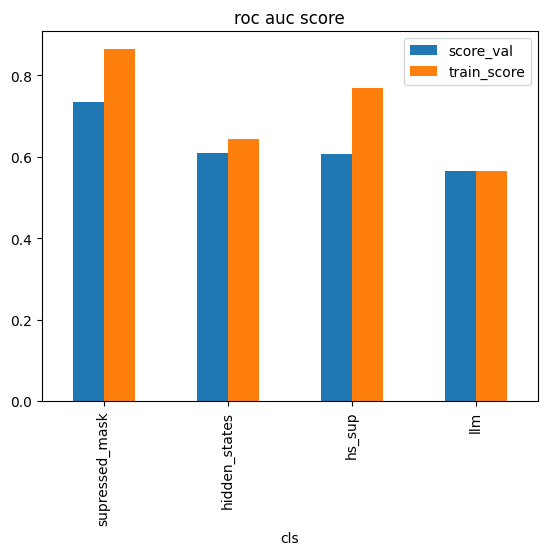

In [188]:
df['cls'] = [x[0] for x in df.index.str.split(' ', expand=True)]
ddf = df.groupby('cls').max().T
ddf['llm'] = llm_score
ddf = ddf.T.sort_values('score_val', ascending=False)
ddf.plot(kind='bar', legend=True, title='roc auc score')
ddf

In [158]:
print(ddf.sort_values('score', ascending=False).to_markdown())

| cls            |    score |
|:---------------|---------:|
| hidden_states  | 0.598214 |
| hs_sup         | 0.596726 |
| llm            | 0.565774 |
| supressed_mask | 0.526339 |
